In [3]:
#General Imports
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.feature_selection import f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random as rnd
from time import perf_counter as time
import numpy as np
from sklearn.impute import SimpleImputer
from preprocessing_utils import drop_features_, fill_nan_values

In [4]:
dataset_fpath = '../data/BTS1_BTS2_fields_preserved.zip'
nidd_dataset = pd.read_csv(dataset_fpath, compression = 'zip', low_memory=False)

#Attack Type for Multi-Class Classification or Label for Binary Classification
TARGET = 'Label'
DROPPED_TARGET = "Label" if TARGET == "Attack Type" else "Attack Type"

useless_features = ['Attack Tool', DROPPED_TARGET, 'Dport', 'Sport', 'SrcAddr', 'DstAddr',"Unnamed: 0"]
nidd_dataset = nidd_dataset.drop(useless_features, axis=1)
print(f"Original shape of data: {nidd_dataset.shape}")

Original shape of data: (1215890, 106)


In [5]:
features_dropped = {"Nan columns": [], "Zero columns": [], "Constant columns": [], "General columns": useless_features}
preprocessing_d = {"Time <Dropping features based on a threshold `bad` values>": 0.,
                   "Filling NaNs": 0.,
                   "Time <Encoding categorical features>": 0.,
                   "Time <Feature selection>": 0.}



nidd_dataset_cleaned, drop_time = drop_features_(nidd_dataset,[0.95, 0.95], features_dropped)
preprocessing_d["Time <Dropping features based on a threshold `bad` values>"] = drop_time

nidd_dataset_cleaned, fill_time = fill_nan_values(nidd_dataset_cleaned, method = "mean")
preprocessing_d["Filling NaNs"] = fill_time

numeric_cols = nidd_dataset_cleaned.select_dtypes(include='number').columns
categorical_cols = nidd_dataset_cleaned.select_dtypes(include='object').columns

t0 = time()
# Encoding categorical columns
label_encoder = LabelEncoder()
for column in categorical_cols:
    nidd_dataset_cleaned[column] = label_encoder.fit_transform(nidd_dataset_cleaned[column])

t1 = time()
preprocessing_d["Time <Encoding categorical features>"] = t1 - t0

After dropping NaN columns: (1215890, 70)
After dropping NaN & Zero columns: (1215890, 55)
After dropping NaN & Zero & Constant columns: (1215890, 51)


In [6]:

feature_extraction_model = RandomForestClassifier(random_state= rnd.seed(42))
feature_extraction_model.fit(nidd_dataset_cleaned.iloc[:,:-1], nidd_dataset_cleaned[TARGET])

print(f"Feature importance: {feature_extraction_model.feature_importances_}")


Feature importance: [7.67123841e-02 4.14921599e-02 2.89419622e-02 3.98312444e-02
 2.01948328e-01 1.85397056e-03 4.74108793e-03 8.55881787e-02
 7.59564471e-04 2.96289437e-03 1.60423733e-03 3.49166103e-03
 6.71892155e-03 1.69138390e-04 1.10083000e-04 8.34960153e-05
 1.02126747e-01 9.22078568e-03 5.55724613e-02 8.94660336e-03
 2.67201071e-03 7.07752972e-04 8.37460774e-03 4.91213918e-04
 8.37522045e-04 2.06735397e-03 1.42897077e-02 1.35247509e-02
 3.52708825e-03 9.84564740e-02 6.39135777e-02 1.51142300e-03
 1.17118033e-03 1.93859986e-03 5.77826928e-05 1.10977338e-02
 1.78371907e-02 5.61181801e-03 2.93375327e-03 1.17046639e-04
 5.27435157e-03 2.03717428e-02 2.18628453e-02 8.64319708e-03
 1.57451814e-03 1.02965143e-06 9.36286148e-03 6.78829870e-03
 1.58951685e-03 5.17141041e-04]


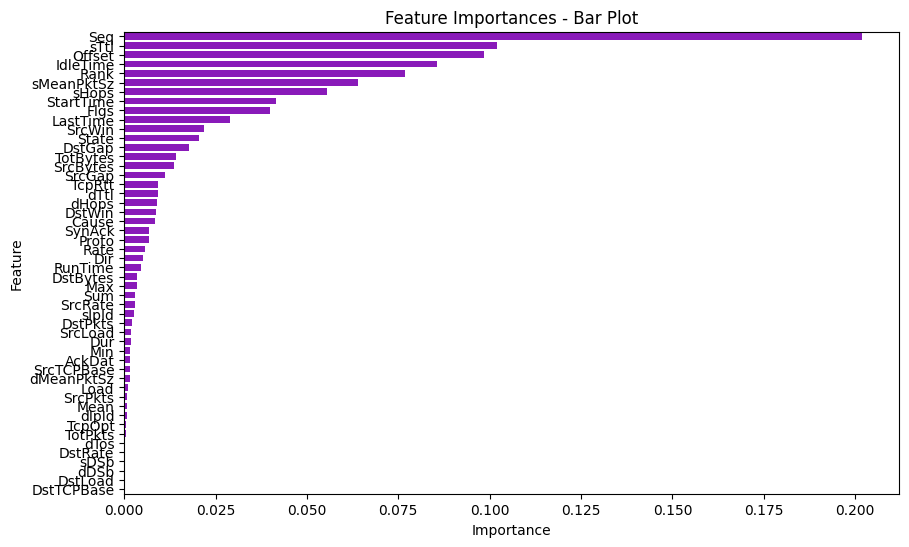

In [7]:
feature_importances_ = pd.DataFrame({'Feature': nidd_dataset_cleaned.iloc[:,:-1].columns, 
                                    'Importance': feature_extraction_model.feature_importances_})

# print(f"Feature importance: {feature_importances_}")
# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importances_.sort_values(by='Importance', ascending=False),
            width = 1.2, gap = 0.4,
            color = "darkviolet")
plt.title('Feature Importances - Bar Plot')
plt.show()




In [18]:

top_10_features_cols = feature_importances_.sort_values(by='Importance', ascending=False).head(10)['Feature'].values
target = nidd_dataset[TARGET]
features = nidd_dataset[top_10_features_cols]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=rnd.seed(42)) 

numeric_features = list(set(numeric_cols) & set(top_10_features_cols))
categorical_features = list(set(categorical_cols) & set(top_10_features_cols))

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)


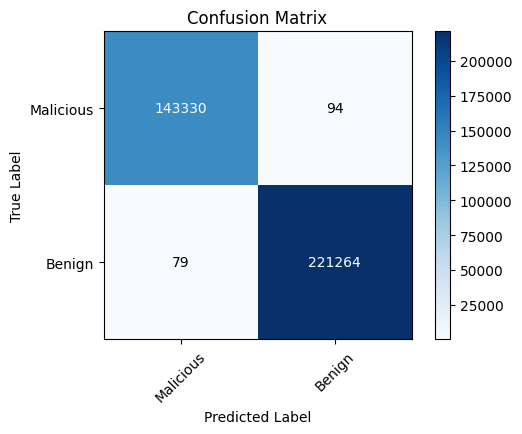

Classification Report:
               precision    recall  f1-score   support

   Malicious   0.999449  0.999345  0.999397    143424
      Benign   0.999575  0.999643  0.999609    221343

    accuracy                       0.999526    364767
   macro avg   0.999512  0.999494  0.999503    364767
weighted avg   0.999526  0.999526  0.999526    364767

Time <Dropping features based on a threshold `bad` values>: 2.2453 seconds
Filling NaNs: 2.1293 seconds
Time <Encoding categorical features>: 1.3498 seconds
Time <Feature selection>: 0.0000 seconds


In [19]:
conf_matrix = confusion_matrix(y_test, predictions)

target_categories = set(nidd_dataset[TARGET])

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(target_categories)), labels=target_categories, rotation=45)
plt.yticks(ticks=np.arange(len(target_categories)), labels=target_categories)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

class_report = classification_report(y_test, predictions, target_names=target_categories , digits=6)
print("Classification Report:\n", class_report)
for key, time in preprocessing_d.items():
    print(f"{key}: {time:.4f} seconds")


      Feature  Importance
2      Offset    0.473514
1        sTtl    0.462487
0         Seq    0.062562
3    IdleTime    0.000349
8        Flgs    0.000313
6       sHops    0.000262
9    LastTime    0.000239
5  sMeanPktSz    0.000124
7   StartTime    0.000111
4        Rank    0.000038


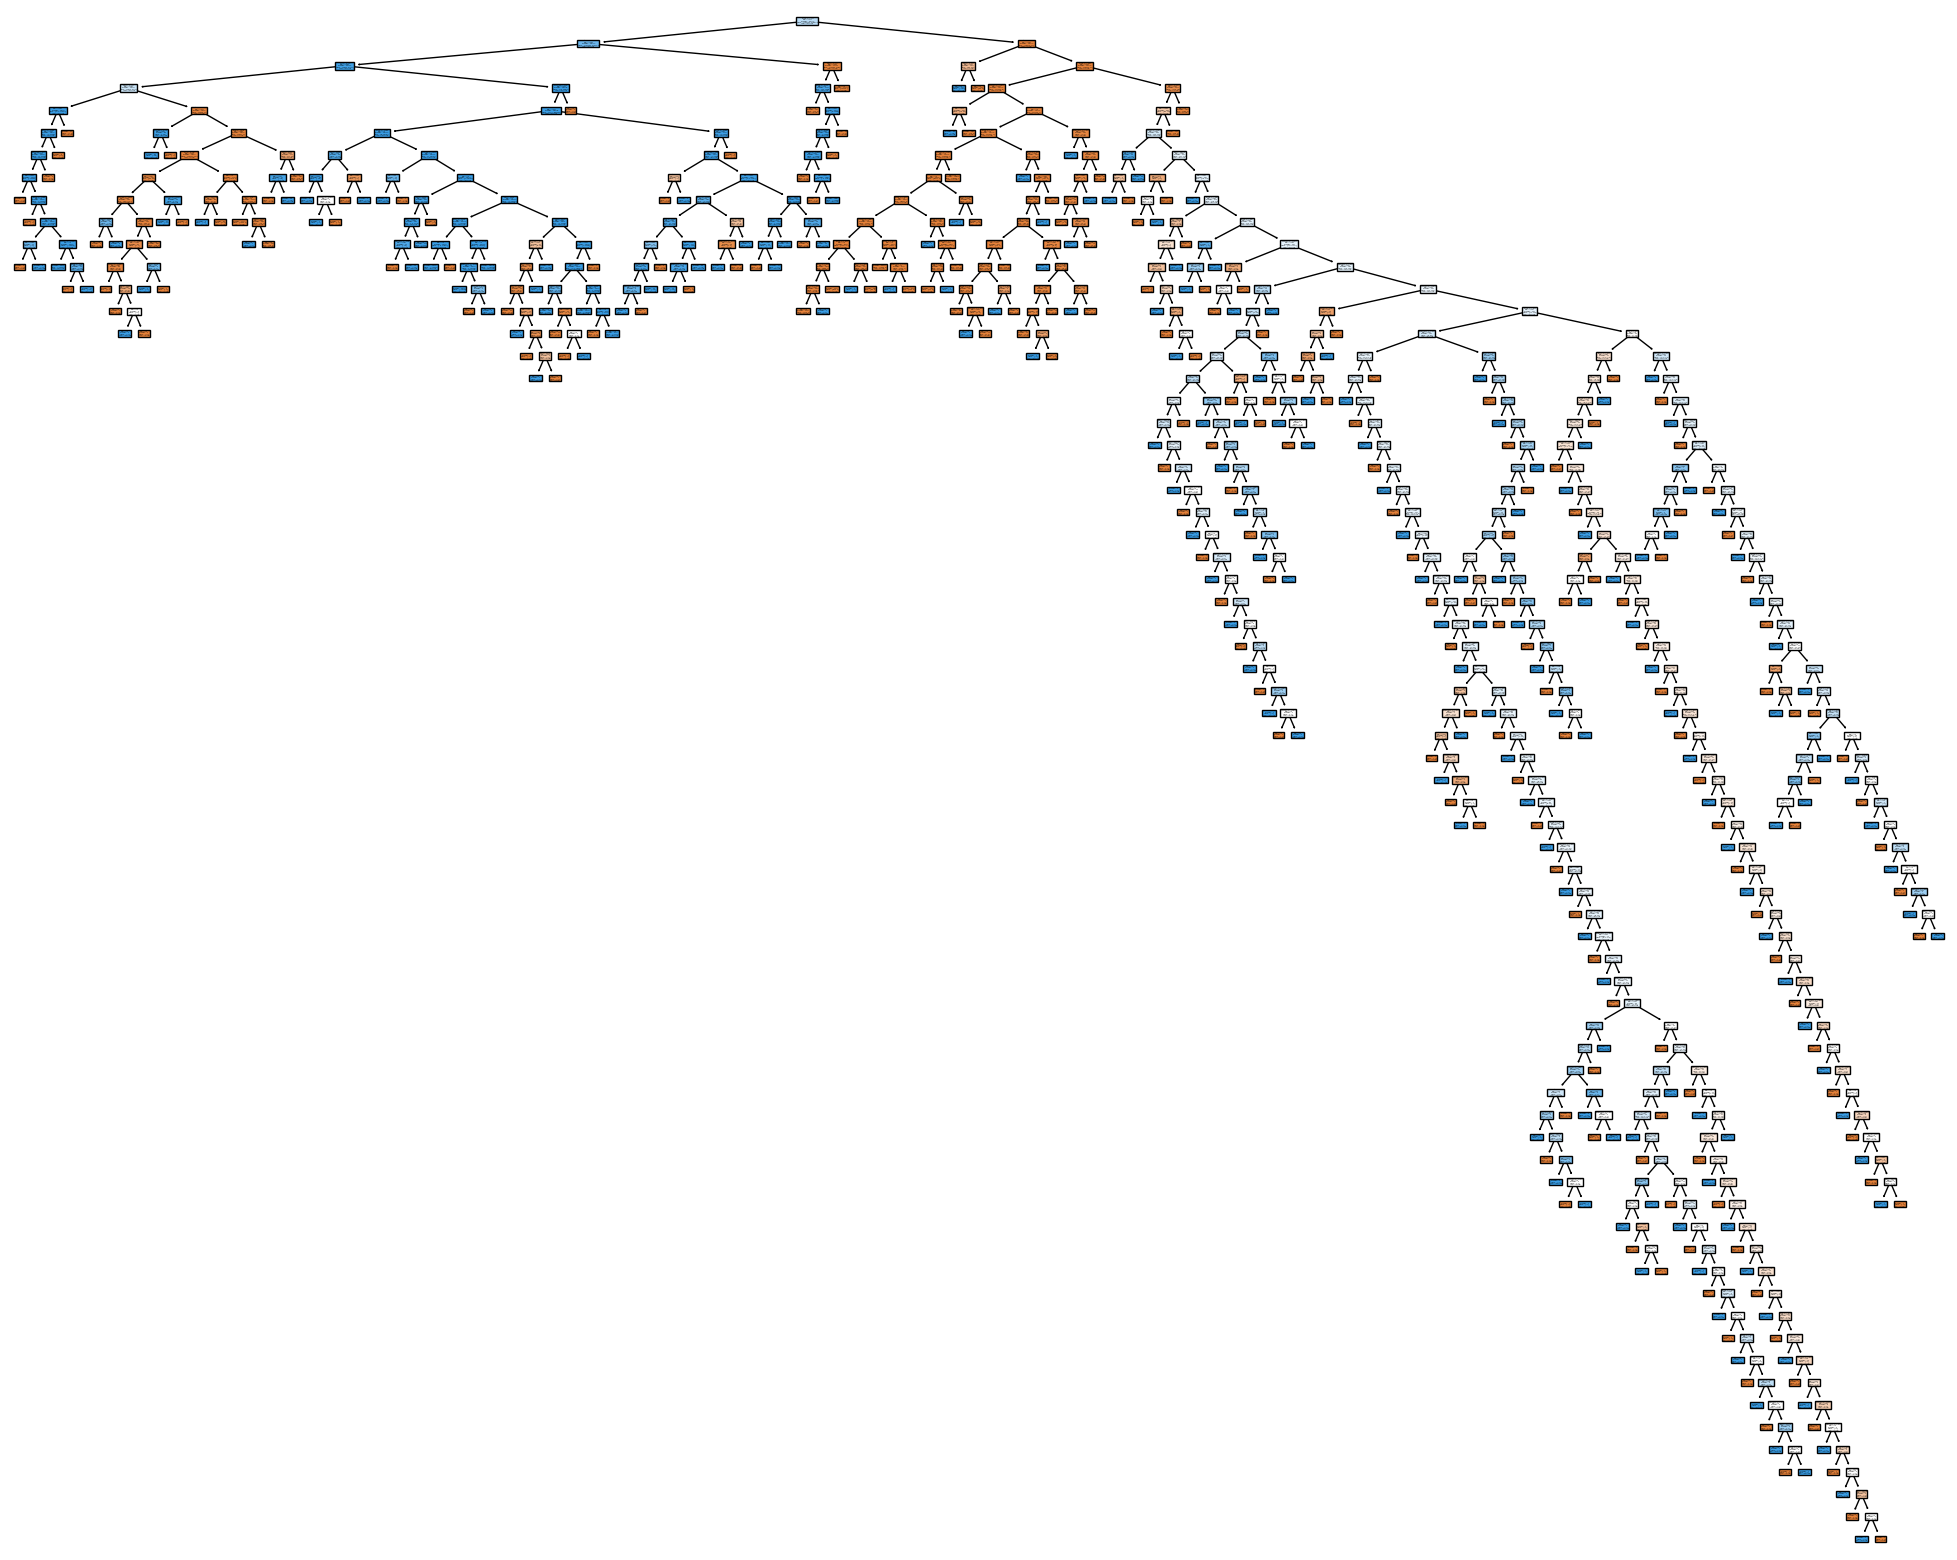

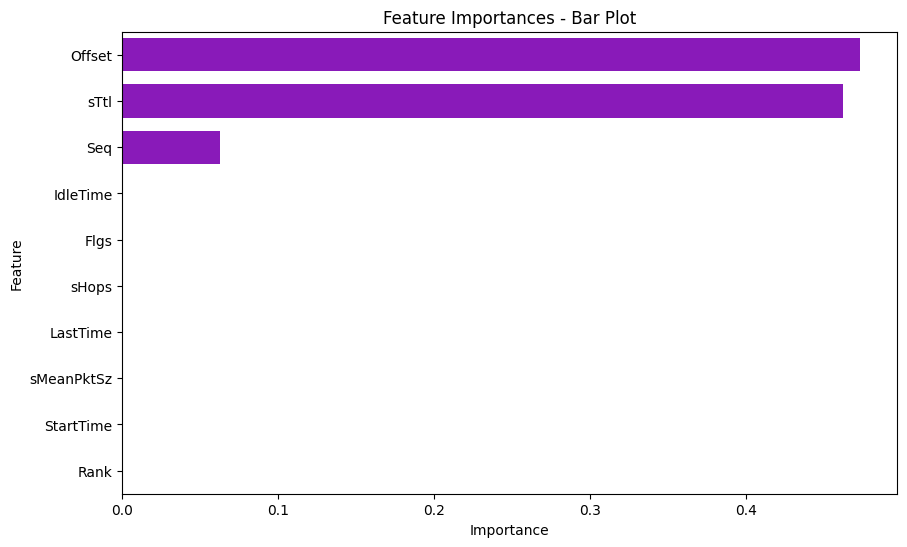

In [25]:

fn=X_test.columns
cn=pipeline['classifier'].classes_
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(pipeline['classifier'], 
                   feature_names=fn,  
                   class_names=cn,
                   filled=True)



rf = pipeline['classifier']
data = list(zip(top_10_features_cols, rf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print(df_importances)


# print(f"Feature importance: {feature_importances_}")
# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', 
            data=df_importances,
            width = 1.2, gap = 0.4,
            color = "darkviolet")
plt.title('Feature Importances - Bar Plot')
plt.show()